<a href="https://colab.research.google.com/github/ErikDeniz/Computacion-Inteligente/blob/main/Electromotor_status_(fuzzy_logic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estado de un motor eléctrico con lógica difusa

En este programa se crea un sistema de **control difuso** que modele el **estado de un motor eléctrico**. Se considerará la **temperatura** (medida en grados centígrados) y la **velocidad** (medida en rpm) del motor, y el porcentaje de **carga** al que está sometido (en porcentaje). Y se obtiene el **porcentaje de vida útil** al que está trabajando el equipo.

Para ello usaremos la librería scikit-fuzzy:

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 993 kB 5.2 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=32b2a136c0cdbc34d949962f4a1bcf2ff43ae77073af6c70a95d955f3cbeb7ed
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


## Antecedentes:



*   **Temperatura**: Se establece un universo, o rango de valores nítidos, de 0 a 155 grados, que tomaremos como una temperatura bastante elevada en la mayoría de motores. Para el conjunto difuso se consideran los niveles low, medium y high.

*   **Velocidad**: Se establece un universo, o rango de valores nítidos, de 0 a 1500 rpm, considerando que trabajamos con un tipo de motores que no superan esta velocidad. Para el conjunto difuso se consideran los niveles slow, medium, fast y veryfast.

*   **Carga**: Se establece un universo, o rango de valores nítidos, de 0 a 100 %, la carga mide el porcentaje de la potencia nominal que está usando, con el máximo rendimiento aproximadamente al 75% de la potencia nominal. Para el conjunto difuso se consideran los niveles low, medium y high.



In [ ]:
# New Antecedent objects hold universe variables and membership
# functions

speed = ctrl.Antecedent(np.arange(0, 1501, 1), 'speed')
temperature = ctrl.Antecedent(np.arange(0, 156, 1), 'temperature')
load = ctrl.Antecedent(np.arange(0, 101, 1), 'load')

# Auto-membership function population is possible with .automf(3, 5, or 7)

speed['slow'] = fuzz.trimf(speed.universe, [0, 0, 300])
speed['medium'] = fuzz.trimf(speed.universe, [250, 500, 800])
speed['fast'] = fuzz.trimf(speed.universe, [700, 1000, 1200])
speed['veryfast'] = fuzz.trimf(speed.universe, [1100, 1400, 1500])

temperature['low'] = fuzz.trimf(temperature.universe, [0, 0, 40])
temperature['medium'] = fuzz.trimf(temperature.universe, [30, 70, 100])
temperature['high'] = fuzz.trimf(temperature.universe, [90, 140, 155])

load['low'] = fuzz.trimf(load.universe, [0, 0, 30])
load['medium'] = fuzz.trimf(load.universe, [20, 30, 60])
load['high'] = fuzz.trimf(load.universe, [50, 75, 100])


## Consecuentes:



*   **Estado**: Se establece un universo, o rango de valores nítidos, de 0 a 100 %, considerando 0% un motor que no está al fin de su vida útil y 100% un motor en condiciones óptimas. Para el conjunto difuso se consideran los niveles averiado, mantenimiento, bueno y muybueno.




In [ ]:
# New Consequent objects hold universe variables and membership
# functions

status = ctrl.Consequent(np.arange(0, 101, 1), 'status')

# Custom membership functions can be built interactively with a familiar,
# Pythonic API

status['averiado'] = fuzz.trimf(status.universe, [0, 0, 20])
status['mantenimiento'] = fuzz.trimf(status.universe, [15, 30, 50])
status['bueno'] = fuzz.trimf(status.universe, [40, 70, 90])
status['muybueno'] = fuzz.trapmf(status.universe, [80, 90, 100, 100])


Representamos gráficamente los conjuntos difusos:

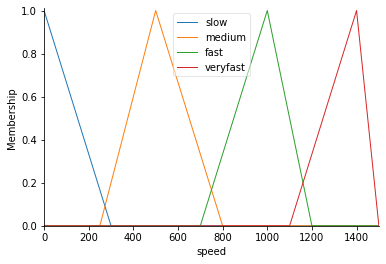

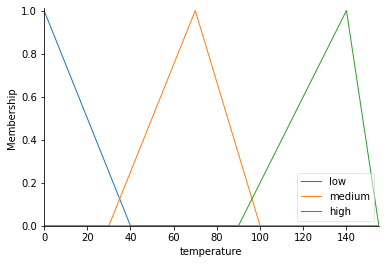

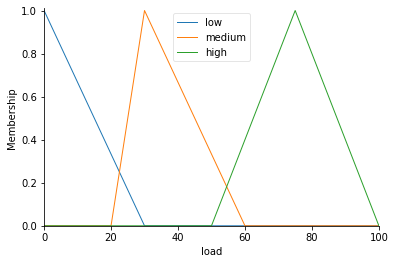

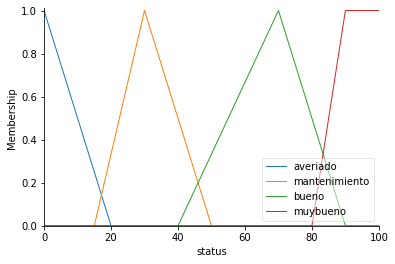

In [ ]:
speed.view()
temperature.view()
load.view()
status.view()

## Reglas:

Por su funcionamiento un motor al que se le aplica una carga alta deberá tener una velocidad alta. La velocidad suele producir rozamiento que aumenta la temperatura. 

Por lo tanto, si alguno de estos valores no es el esperado según la operativa del motor se considerará que no está funcionando correctamente. Una ligera desviación puede ser debido a una falta de mantenimiento o al propio desgaste del motor, mientras que una desviación más grande, como que el motor se caliente cuando va despacio, sería un motivo de avería y debe hacerse una reparación.

In [ ]:
#reglas

rule1 = ctrl.Rule(speed['slow'] & (temperature['low']) & (load['low']), status['muybueno'])
rule2 = ctrl.Rule(speed['slow'] & (temperature['medium']) & (load['medium']), status['mantenimiento'])
rule3 = ctrl.Rule(speed['slow'] & (temperature['high']) | (load['high']), status['averiado'])


rule4 = ctrl.Rule(speed['medium'] & (temperature['high']) | (load['high']), status['averiado'])
rule5 = ctrl.Rule(speed['medium'] & (temperature['medium']) & (load['medium']), status['bueno'])
rule6 = ctrl.Rule(speed['medium'] & (temperature['low']) & (load['low']), status['mantenimiento'])

rule7 = ctrl.Rule(speed['fast'] & (temperature['medium']) & (load['medium']), status['muybueno'])
rule8 = ctrl.Rule(speed['fast'] & (temperature['high']) | (load['high']), status['mantenimiento'])


rule9 = ctrl.Rule(speed['veryfast'] & load['medium'], status['averiado'])
rule10 = ctrl.Rule(speed['veryfast'] & temperature['high']|(load['high']), status['bueno'])

rule11 = ctrl.Rule(load['high'] & temperature['low']|(speed['slow']), status['averiado'])
rule12 = ctrl.Rule(load['high'] & temperature['medium']|(speed['medium']), status['averiado'])




In [ ]:
status_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7,  rule8, rule9, rule10,rule12])
quality = ctrl.ControlSystemSimulation(status_ctrl)


## Uso:

Si se le pide al controlador que nos estime el estado de un motor que gira a 700 rpm, cuando le estamos dando una carga del 100% y medimos una temperatura de 40°C, éste nos estimará que el motor está a un 8,44% de su vida útil. 

Los valores de temperatura y velocidad son adecuados entre sí, pero si se le aplica una carga del 100% de su potencia nominal el motor debería girar a su velocidad máxima.


8.444444444444443


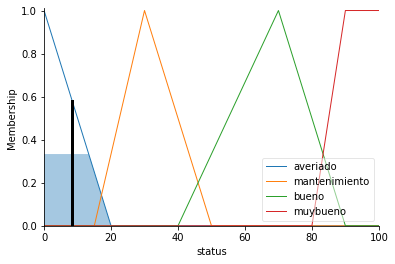

In [ ]:
quality.input['speed'] = 700
quality.input['temperature'] = 40
quality.input['load'] = 100

quality.compute()
print (quality.output['status'])
status.view(sim=quality)

Si se le pide al controlador que nos estime el estado de un motor que gira a 700 rpm, cuando le estamos dando una carga del 50% y medimos una temperatura de 60°C, éste nos estimará que el motor está a un 49,4% de su vida útil. 

En este caso el motor está a mitad de carga dando una velocidad y temperatura más adecuada a la carga.


49.39682539682538


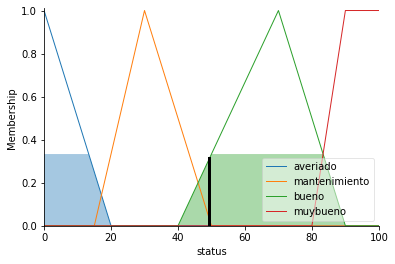

In [ ]:
quality.input['speed'] = 700
quality.input['temperature'] = 60
quality.input['load'] = 50

quality.compute()
print (quality.output['status'])

status.view(sim=quality)